<h3>Random Forest Classifier - Respondent 1 </h3>

<h2>Pre-processing</h2>

In [3]:
import pandas as pd

# Load the CSV file
file_path = '001-b45731a0_emotions_with_cognitive_tesk_and_screen.csv'
data = pd.read_csv(file_path)

# Print the column names
print("Column names:")
print(data.columns)

# Drop rows with NaN values in the target column
data = data.dropna(subset=['Cognitive Task'])
data.head()


Column names:
Index(['Timestamp', 'Anger', 'Contempt', 'Disgust', 'Fear', 'Joy', 'Sadness',
       'Surprise', 'Engagement', 'Valence', 'Sentimentality', 'Confusion',
       'Cognitive Task', 'Screens'],
      dtype='object')


,Timestamp,Anger,Contempt,Disgust,Fear,Joy,Sadness,Surprise,Engagement,Valence,Sentimentality,Confusion,Cognitive Task,Screens
3705,162011.0,0.125566,0.136948,0.021518,0.116770,0.041248,0.112264,0.059114,0.328766,0.0,0.976782,0.036977,Data Exploration,Map
3706,162044.0,0.125566,0.137617,0.021531,0.132963,0.040812,0.112249,0.067522,0.328766,0.0,0.911952,0.034095,Data Exploration,Map
3707,162076.0,0.125566,0.137096,0.021582,0.169795,0.040925,0.111568,0.087434,0.328766,0.0,0.831274,0.026797,Data Exploration,Map
3708,162108.0,0.125566,0.136868,0.021714,0.218535,0.041063,0.111219,0.114075,0.328766,0.0,0.829263,0.019318,Data Exploration,Map
3709,162140.0,0.125566,0.137239,0.021806,0.256706,0.040785,0.110944,0.135015,0.328766,0.0,0.773583,0.014509,Data Exploration,Map


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load the CSV file
file_path = '001-b45731a0_emotions_with_cognitive_tesk_and_screen.csv'
data = pd.read_csv(file_path)

# Drop the Timestamp column
data = data.drop('Timestamp', axis=1)

# Drop rows with NaN values in the target column
data = data.dropna(subset=['Cognitive Task'])
print(data.head())

# Identify numeric and categorical features
# Identify numeric and categorical features, excluding the target variable
all_columns = data.columns.tolist()
target_column = 'Cognitive Task'
all_columns.remove(target_column)
numeric_features = data[all_columns].select_dtypes(include=['int64', 'float64']).columns
categorical_features = data[all_columns].select_dtypes(include=['object']).columns


# Exclude the target column from the numeric features
numeric_features = numeric_features.drop('Cognitive Task', errors='ignore')

# Define the preprocessing steps for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine the preprocessing steps into a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Preprocess the data
y = data['Cognitive Task']
X = data.drop('Cognitive Task', axis=1)
X_preprocessed = preprocessor.fit_transform(X)

# Get the transformed feature names for the categorical columns
cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)

# Combine the numeric and transformed categorical feature names
all_feature_names = list(numeric_features) + list(cat_feature_names)

# Convert the preprocessed data back to a DataFrame
X_preprocessed = pd.DataFrame(X_preprocessed, columns=all_feature_names)

# Reset the index of y
y.reset_index(drop=True, inplace=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)


         Anger  Contempt   Disgust      Fear       Joy   Sadness  Surprise  \
3705  0.125566  0.136948  0.021518  0.116770  0.041248  0.112264  0.059114   
3706  0.125566  0.137617  0.021531  0.132963  0.040812  0.112249  0.067522   
3707  0.125566  0.137096  0.021582  0.169795  0.040925  0.111568  0.087434   
3708  0.125566  0.136868  0.021714  0.218535  0.041063  0.111219  0.114075   
3709  0.125566  0.137239  0.021806  0.256706  0.040785  0.110944  0.135015   

      Engagement  Valence  Sentimentality  Confusion    Cognitive Task Screens  
3705    0.328766      0.0        0.976782   0.036977  Data Exploration     Map  
3706    0.328766      0.0        0.911952   0.034095  Data Exploration     Map  
3707    0.328766      0.0        0.831274   0.026797  Data Exploration     Map  
3708    0.328766      0.0        0.829263   0.019318  Data Exploration     Map  
3709    0.328766      0.0        0.773583   0.014509  Data Exploration     Map  


<h2>Random Forest Classifier</h2>

Confusion Matrix:
 [[4354   16    0   13    5  100   27]
 [  71 1181    0    0    4   73    0]
 [   0    0  119    0   11    0    0]
 [  11    0    0 1349    0    1  115]
 [  80    6    2    0 1389   52    0]
 [ 186   31    0    0   12 3983    0]
 [   0    0    0   55    0    0 1882]]

Classification Report:
                      precision    recall  f1-score   support

     Assess Results       0.93      0.96      0.94      4515
           Conclude       0.96      0.89      0.92      1329
   Data Exploration       0.98      0.92      0.95       130
              Focus       0.95      0.91      0.93      1476
Generate Hypothesis       0.98      0.91      0.94      1529
           Set Goal       0.95      0.95      0.95      4212
    Test Hypothesis       0.93      0.97      0.95      1937

           accuracy                           0.94     15128
          macro avg       0.95      0.93      0.94     15128
       weighted avg       0.94      0.94      0.94     15128


Accuracy Score

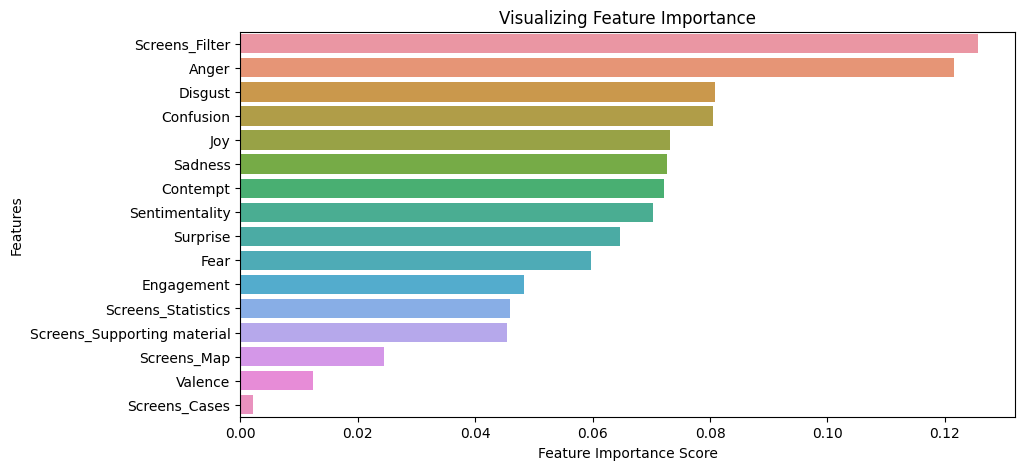

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Train the Random Forest model
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Test the model
y_pred = model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

# Plot the feature importance
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Feature Importance')
plt.show()


In [8]:
from sklearn.model_selection import cross_val_score

# Use 5-fold cross-validation to evaluate the model
cv_scores = cross_val_score(model, X_preprocessed, y, cv=5)
print("Average cross-validation score:", np.mean(cv_scores))


Average cross-validation score: 0.4603516657852989
